In [1]:
import os
import pandas as pd
import numpy as np
import torch
import timeit

import cupy as cp
cp.random.seed(12)

#### Portions of this were borrowed and adapted from the
#### cuDF cheatsheet, existing cuDF documentation,
#### and 10 Minutes to Pandas.

In [2]:
import time

import cupy as cp
import cudf
from cuml.neighbors import NearestNeighbors
from cuml.common.device_selection import using_device_type, set_global_device_type, get_global_device_type

# import dask_cudf
# from dask.distributed import Client, wait
# from dask_cuda import LocalCUDACluster



In [3]:
# cluster = LocalCUDACluster(n_workers=1, threads_per_worker=512)
# client = Client(cluster)

In [4]:
# Generate a "coordinate" dataframe
n_points = 400000
#df = cudf.DataFrame()

point_cloud = torch.cuda.FloatTensor(n_points, 3).uniform_()

# df['x'] = point_cloud[:, 0]
# df['y'] = point_cloud[:, 1]
# df['z'] = point_cloud[:, 2]

# Generate random data for the DataFrame
random_data = np.array(point_cloud.cpu())

# Create the cudf.DataFrame
df = cudf.DataFrame(random_data, columns=["X", "Y", "Z"])

In [5]:
# ddf = dask_cudf.from_cudf(df, npartitions=1)
# ddf.head()

# ddf = ddf.persist()

In [6]:
n_neighbors = 16

In [7]:
from cuml.datasets import make_blobs
from time import perf_counter

# # Generate random data for the DataFrame
# random_data2 = np.random.rand(n_points, 3)

# # Create the cudf.DataFrame
# fit_df = cudf.DataFrame(random_data2, columns=["X", "Y", "Z"])

# fit model
model = NearestNeighbors(n_neighbors=n_neighbors)
model.fit(df)

# start_time = perf_counter()

# # get 3 nearest neighbors
# distances_fit, indices_fit = model.kneighbors(fit_df)

# end_time = perf_counter()
# print(f"Average execution time with blobs: {end_time-start_time:.6f} seconds")


start_time = perf_counter()

# get 3 nearest neighbors
distances1, indices1 = model.kneighbors(df)

end_time = perf_counter()
print(f"Average execution time with common data: {end_time-start_time:.6f} seconds")

Average execution time with common data: 0.630006 seconds


In [8]:
# fit_df.shape == df.shape

In [9]:

def autoSearchAlgorithm(df_input):
    # Create a cuML NearestNeighbors model
    nn = NearestNeighbors(n_neighbors=n_neighbors)

    # Compute the Dask DataFrame
    # ddf_computed = ddf.compute()

    # Fit the model with the input data
    nn.fit(df_input)

    start_time = timeit.default_timer()

    # Get the nearest neighbors
    distances2, indices2 = nn.kneighbors(df_input)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"auto Execution time: {execution_time} seconds")
    # print(indices.compute())

    return distances2, indices2, execution_time


In [10]:
distances2, indices2, execution_time_auto = autoSearchAlgorithm(df)

auto Execution time: 0.6234844909999993 seconds


In [11]:
indices1.head() == indices2.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [12]:
def rbcSearchAlgorithm(df_input):
    # Create a cuML NearestNeighbors model
    nn2 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='rbc')

    # Fit the model with the input data
    nn2.fit(df_input)

    start_time = timeit.default_timer()

    # Get the nearest neighbors
    distances3, indices3 = nn2.kneighbors(df_input)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"rbc Execution time: {execution_time} seconds")

    return distances3, indices3, execution_time

distances3, indices3, execution_time_rbc = rbcSearchAlgorithm(df)


rbc Execution time: 0.6163675840000025 seconds


In [13]:
indices2.head() == indices3.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True


In [14]:
import pandas as pd
import torch

def ivfflatSearchAlgorithm(df_input, nlist_input, nprobe_input):
    # Create a cuML NearestNeighbors model
    nn3 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ivfflat', algo_params={'nlist': nlist_input, 'nprobe': nprobe_input})

    # nn3 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ivfflat')

    # Fit the model with the input data
    nn3.fit(df_input)

    start_time = timeit.default_timer()

    # Get the nearest neighbors
    distances4, indices4 = nn3.kneighbors(df_input)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"ivfflat Execution time: {execution_time} seconds")

    return distances4, indices4, execution_time

distances_ivfflat, indices_ivfflat, execution_time_ivfflat = ivfflatSearchAlgorithm(df, 100, 2)

# import matplotlib.pyplot as plt

# # List of n_points values
# n_points_list = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000] # Do not use a number above 5500000 if your GPU Memory is 16GB

# # List of nlist values
# nlist_values = [50, 100, 200, 500]

# # List of nprobe values
# nprobe_values = [2, 4, 8]

# # Lists to store execution times for each function
# execution_times_ivfflat = []

# # Initialize an empty list to store the rows
# rows = []

# # Loop over n_points values
# for n_points in n_points_list:

#     print(f"Current n_points: {n_points}")

#     # Generate random data for the DataFrame
#     point_cloud_ivfflat = torch.cuda.FloatTensor(n_points, 3).uniform_()

#     # Generate random data for the DataFrame
#     random_data_ivfflat = np.array(point_cloud_ivfflat.cpu())

#     # Create the cudf.DataFrame
#     df_ivfflat = cudf.DataFrame(random_data_ivfflat, columns=["X", "Y", "Z"])

#     # Loop over nlist values
#     for nlist in nlist_values:

#         # Loop over nprobe values
#         for nprobe in nprobe_values:

#             print(f"Current nlist: {nlist}, nprobe: {nprobe}")

#             # Call the function and measure execution time
#             distances_ivfflat, indices_ivfflat, execution_time_ivfflat = ivfflatSearchAlgorithm(df_ivfflat, nlist, nprobe)

#             # Append a new row to the list
#             rows.append({
#                 'n_points': n_points,
#                 'nlist': nlist,
#                 'nprobe': nprobe,
#                 'execution_time_ivfflat': execution_time_ivfflat
#             })

# # Create a DataFrame from the list of rows
# execution_times_df = pd.DataFrame(rows)

# # Plotting the execution times
# fig, ax = plt.subplots(figsize=(10, 6))

# # Group the data by nlist and nprobe
# grouped_data = execution_times_df.groupby(['nlist', 'nprobe'])

# # Iterate over the groups and plot the execution times
# for group, data in grouped_data:
#     nlist, nprobe = group
#     ax.plot(data['n_points'], data['execution_time_ivfflat'], label=f"nlist={nlist}, nprobe={nprobe}")

# ax.set_xlabel('n_points')
# ax.set_ylabel('Execution Time (seconds)')
# ax.set_title('Execution Time of ivfflatSearchAlgorithm')
# ax.legend()
# plt.show()


# # Find the row with the lowest execution time
# best_row = execution_times_df['execution_time_ivfflat'].idxmin()

# # Extract the corresponding nlist and nprobe values
# best_nlist = execution_times_df.loc[best_row, 'nlist']
# best_nprobe = execution_times_df.loc[best_row, 'nprobe']

# print(f"The best nlist and nprobe combination is nlist={best_nlist}, nprobe={best_nprobe}.")

# import pandas as pd

# # Create a DataFrame with the best_nprobe and best_nlist values
# data = {'best_nprobe': [best_nprobe], 'best_nlist': [best_nlist]}
# df = pd.DataFrame(data)

# # Save the DataFrame to a CSV file
# df.to_csv('best_values.csv', index=False)


/home/jabl91/miniconda3/envs/pointcept_py_3_9/lib/python3.9/site-packages/cuml/internals/api_decorators.py:190: UserWarning: 
  return func(*args, **kwargs)


ivfflat Execution time: 1.092290388000002 seconds


In [15]:
# Read the CSV file
df = pd.read_csv('best_values.csv')

# Update the values of best_nprobe and best_nlist
best_nprobe = df['best_nprobe'].values[0]
best_nlist = df['best_nlist'].values[0]


In [16]:
import torch
import pointops

def knn_query_pointopsv1(n_neighbors_input, point_cloud_input, n_points_input):
    n_points_tensor = torch.cuda.FloatTensor([n_points_input])

    start_time = timeit.default_timer()

    reference_index, distanceindex = pointops.knn_query(n_neighbors_input, point_cloud_input, n_points_tensor)

    torch.cuda.synchronize()

    reference_index_cpu = reference_index.cpu()

    # print(reference_index)

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"C++ PointopsV1 KNN Execution time: {execution_time} seconds")
    # print(reference_index.shape)

    return reference_index_cpu, execution_time, distanceindex

reference_index_cpu, execution_time_pointopsv1, distanceindex_pointopsv1 = knn_query_pointopsv1(n_neighbors, point_cloud, n_points)

C++ PointopsV1 KNN Execution time: 0.22524807299999594 seconds


C++ PointopsV1 KNN Execution time: 0.2216615189999942 seconds
ivfflat Execution time: 0.06238711600000357 seconds
The content differs between distanceindex_pointopsv1 and distances_ivfflat.
Number of differences: 2440846
Total number of items: 6400000


/home/jabl91/miniconda3/envs/pointcept_py_3_9/lib/python3.9/site-packages/cuml/internals/api_decorators.py:190: UserWarning: 
  return func(*args, **kwargs)


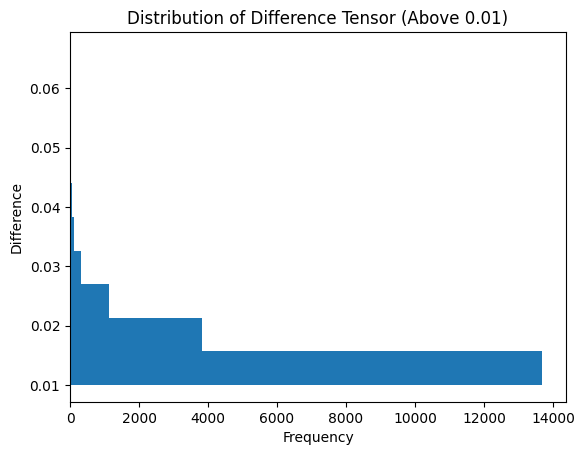

Percentage of elements above 0.01: 0.298828125%


In [17]:
import torch
# Generate a "coordinate" dataframe
n_points = 400000
#df = cudf.DataFrame()

point_cloud = torch.cuda.FloatTensor(n_points, 3).uniform_()

# df['x'] = point_cloud[:, 0]
# df['y'] = point_cloud[:, 1]
# df['z'] = point_cloud[:, 2]

# Generate random data for the DataFrame
random_data = np.array(point_cloud.cpu())

# Create the cudf.DataFrame
df = cudf.DataFrame(random_data, columns=["X", "Y", "Z"])




reference_index_cpu, execution_time_pointopsv1, distanceindex_pointopsv1 = knn_query_pointopsv1(n_neighbors, point_cloud, n_points)

distances_ivfflat, indices_ivfflat, execution_time_ivfflat = ivfflatSearchAlgorithm(df, best_nlist, best_nprobe)

# Apply square root to all elements on distanceindex_pointopsv1 to make it compatible with distances_ivfflat
distanceindex_pointopsv1= torch.sqrt(distanceindex_pointopsv1)

# Convert distanceindex_pointopsv1 to a PyTorch Tensor
distanceindex_pointopsv1_tensor = torch.cuda.FloatTensor(distanceindex_pointopsv1)

# Convert distances_ivfflat DataFrame to a Tensor
distances_ivfflat_tensor = torch.cuda.FloatTensor(distances_ivfflat.values)

# Compare the content element-wise
are_equal = torch.allclose(distanceindex_pointopsv1_tensor, distances_ivfflat_tensor)

if are_equal:
    print("The content of distanceindex_pointopsv1 and distances_ivfflat is equal.")
else:
    print("The content differs between distanceindex_pointopsv1 and distances_ivfflat.")


# Compare element-wise equality
elementwise_equal = torch.eq(distanceindex_pointopsv1_tensor, distances_ivfflat_tensor)

# Count the number of differences
num_differences = torch.sum(~elementwise_equal).item()

# Get the total number of items
total_items = distanceindex_pointopsv1_tensor.numel()

print(f"Number of differences: {num_differences}")
print(f"Total number of items: {total_items}")


# Calculate the element-wise difference between the tensors
difference = torch.abs(distanceindex_pointopsv1_tensor - distances_ivfflat_tensor)

# Calculate the max, min, and mean difference
max_difference = difference.max().item()
min_difference = difference.min().item()
mean_difference = difference.mean().item()

max_difference, min_difference, mean_difference


import matplotlib.pyplot as plt

# Flatten the difference tensor and move it to CPU
difference_flat = difference.cpu().flatten()

# Filter the difference values above 0.01
filtered_difference = difference_flat[difference_flat > 0.01]

# Plot the histogram
plt.hist(filtered_difference, bins=10, orientation='horizontal')

# Set the labels and title
plt.xlabel('Frequency')
plt.ylabel('Difference')
plt.title('Distribution of Difference Tensor (Above 0.01)')

# Show the plot
plt.show()


# Flatten the difference tensor and move it to CPU
difference_flat = difference.cpu().flatten()

# Filter the difference values above 0.01
filtered_difference = difference_flat[difference_flat > 0.01]

# Calculate the percentage
percentage = (len(filtered_difference) / total_items) * 100

# Print the percentage
print(f"Percentage of elements above 0.01: {percentage}%")




In [18]:
# Calculate the element-wise difference between the tensors
difference = torch.abs(distanceindex_pointopsv1_tensor - distances_ivfflat_tensor)

# Find the indices where the difference is greater than 0.01
indices_greater_than_0_01 = torch.nonzero(difference > 0.01)

# Print the indices
print(len(indices_greater_than_0_01))

19125


In [19]:
print(type(indices1))
print(type(reference_index_cpu))

# Assuming you have a cuDF DataFrame (cudf_df) and a PyTorch Tensor (torch_tensor)
# Extract the data from the cuDF DataFrame
indices1_data = indices1.to_pandas().values

# Convert the cuDF data to a PyTorch Tensor
torch_indices1_data = torch.tensor(indices1_data).to(torch.int32)

# Compare the content element-wise
are_equal = torch.equal(torch_indices1_data, reference_index_cpu)

if are_equal:
    print("The content of the cuDF DataFrame and PyTorch Tensor is equal.")
else:
    print("The content differs between the cuDF DataFrame and PyTorch Tensor.")

<class 'cudf.core.dataframe.DataFrame'>
<class 'torch.Tensor'>
The content differs between the cuDF DataFrame and PyTorch Tensor.


In [20]:
# Compare element-wise equality
elementwise_equal = torch.eq(torch_indices1_data, reference_index_cpu)

# Find indices where elements are different (i.e., where elementwise_equal is False)
differing_indices = torch.nonzero(~elementwise_equal)


print(differing_indices)
print(torch_indices1_data)
print(reference_index_cpu)

tensor([[     0,      1],
        [     0,      2],
        [     0,      3],
        ...,
        [399999,     13],
        [399999,     14],
        [399999,     15]])
tensor([[     0, 187507,  27433,  ..., 129936, 103257, 265743],
        [     1, 398421, 279661,  ..., 296387,  78334,  36540],
        [     2, 162456, 105212,  ..., 196101, 197082,  57744],
        ...,
        [399997, 338584, 384101,  ..., 349254, 171420, 351163],
        [399998,  20345, 264140,  ...,  51271, 351898, 355020],
        [399999, 122695, 148461,  ..., 274681, 224233, 241293]],
       dtype=torch.int32)
tensor([[     0,  71909, 370681,  ..., 294650, 288440, 205407],
        [     1, 237205, 107950,  ..., 230664, 325177,   4620],
        [     2, 146701,  58913,  ..., 371326, 311946, 217673],
        ...,
        [399997, 355770, 364602,  ..., 230516, 266517, 194462],
        [399998, 266176, 165175,  ...,  47462,  46840, 379879],
        [399999, 329548,  52259,  ...,  85929, 153748, 397488]],
       d

In [21]:
import torch
from pointops2 import pointops2 as newerPointOps2

def knn_query_pointopsv2(n_neighbors_input, point_cloud_input, n_points_input):
    n_points_tensor = torch.cuda.FloatTensor([n_points_input])

    start_time = timeit.default_timer()

    reference_index, distance_indices = newerPointOps2.knnquery(n_neighbors_input, point_cloud_input, None, n_points_tensor, n_points_tensor)

    torch.cuda.synchronize()

    reference_index_cpu2 = reference_index.cpu()

    end_time = timeit.default_timer()
    execution_time = end_time - start_time
    print(f"C++ PointopsV2 KNN Execution time: {execution_time} seconds")
    # print(reference_index)

    return reference_index_cpu2, execution_time, distance_indices

reference_index_cpu2, execution_time_pointopsv2, distanceindex_pointopsv2 = knn_query_pointopsv2(n_neighbors, point_cloud, n_points)

C++ PointopsV2 KNN Execution time: 0.23791353000000015 seconds


In [22]:
print(type(indices1))
print(type(reference_index_cpu2))

# Assuming you have a cuDF DataFrame (cudf_df) and a PyTorch Tensor (torch_tensor)
# Extract the data from the cuDF DataFrame
indices1_data = indices1.to_pandas().values

# Convert the cuDF data to a PyTorch Tensor
torch_indices1_data = torch.tensor(indices1_data).to(torch.int32)

# Compare the content element-wise
are_equal = torch.equal(torch_indices1_data, reference_index_cpu2)

if are_equal:
    print("The content of the cuDF DataFrame and PyTorch Tensor is equal.")
else:
    print("The content differs between the cuDF DataFrame and PyTorch Tensor.")

<class 'cudf.core.dataframe.DataFrame'>
<class 'torch.Tensor'>
The content differs between the cuDF DataFrame and PyTorch Tensor.


In [23]:
# Compare element-wise equality
elementwise_equal = torch.eq(torch_indices1_data, reference_index_cpu2)

# Find indices where elements are different (i.e., where elementwise_equal is False)
differing_indices2 = torch.nonzero(~elementwise_equal)


print(differing_indices2)
print(torch_indices1_data)
print(reference_index_cpu2)

tensor([[     0,      1],
        [     0,      2],
        [     0,      3],
        ...,
        [399999,     13],
        [399999,     14],
        [399999,     15]])
tensor([[     0, 187507,  27433,  ..., 129936, 103257, 265743],
        [     1, 398421, 279661,  ..., 296387,  78334,  36540],
        [     2, 162456, 105212,  ..., 196101, 197082,  57744],
        ...,
        [399997, 338584, 384101,  ..., 349254, 171420, 351163],
        [399998,  20345, 264140,  ...,  51271, 351898, 355020],
        [399999, 122695, 148461,  ..., 274681, 224233, 241293]],
       dtype=torch.int32)
tensor([[     0,  71909, 370681,  ..., 294650, 288440, 205407],
        [     1, 237205, 107950,  ..., 230664, 325177,   4620],
        [     2, 146701,  58913,  ..., 371326, 311946, 217673],
        ...,
        [399997, 355770, 364602,  ..., 230516, 266517, 194462],
        [399998, 266176, 165175,  ...,  47462,  46840, 379879],
        [399999, 329548,  52259,  ...,  85929, 153748, 397488]],
       d

In [24]:
torch.equal(differing_indices2, differing_indices)

True

In [25]:
# # Create a cuML NearestNeighbors model
# nn4 = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ivfpq')
# # Compute the Dask DataFrame
# ddf_computed = ddf.compute()

# start_time = timeit.default_timer()



# # Fit the model with the input data
# nn4.fit(ddf_computed)

# # Get the nearest neighbors
# distances, indices = nn4.kneighbors(ddf_computed)

# end_time = timeit.default_timer()
# execution_time = end_time - start_time
# print(f"ivfflat Execution time: {execution_time} seconds")

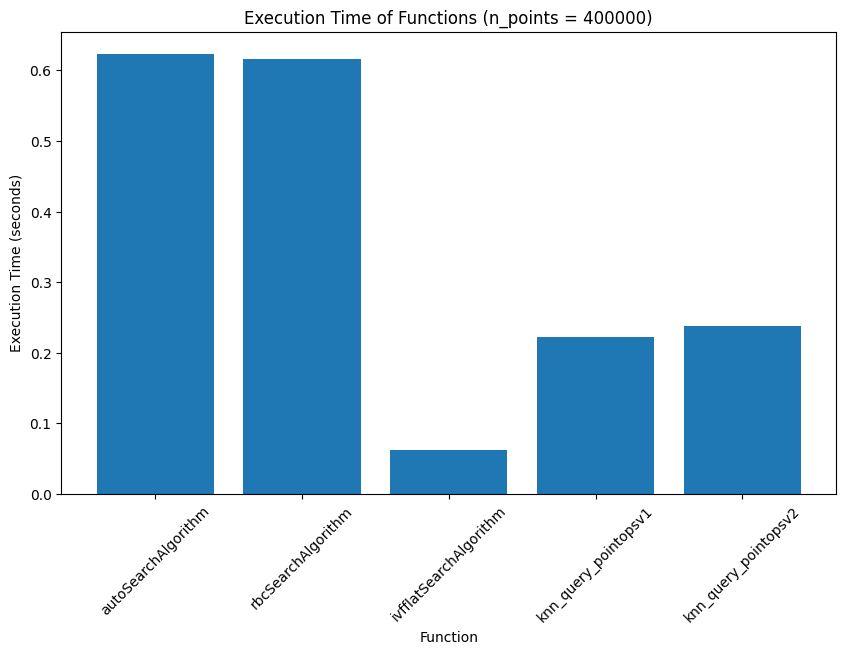

In [26]:
import matplotlib.pyplot as plt

# Execution times of each function
execution_times = [execution_time_auto, execution_time_rbc, execution_time_ivfflat, execution_time_pointopsv1, execution_time_pointopsv2]

# Function names
function_names = ['autoSearchAlgorithm', 'rbcSearchAlgorithm', 'ivfflatSearchAlgorithm', 'knn_query_pointopsv1', 'knn_query_pointopsv2']

# Number of n_points
n_points_used = n_points

# Plotting the execution times
plt.figure(figsize=(10, 6))
plt.bar(function_names, execution_times)
plt.xlabel('Function')
plt.ylabel('Execution Time (seconds)')
plt.title(f'Execution Time of Functions (n_points = {n_points_used})')
plt.xticks(rotation=45)
plt.show()


Current n_points: 5000
auto Execution time: 0.0132510490000044 seconds
rbc Execution time: 0.010955705000000648 seconds
ivfflat Execution time: 0.010752973999998972 seconds
C++ PointopsV1 KNN Execution time: 0.001444978000002095 seconds
C++ PointopsV2 KNN Execution time: 0.000925985000002072 seconds
Number of differences between indices_auto and indices_rbc: 0
Number of differences between indices_auto and indices_ivfflat: 22526
Number of differences between indices_rbc and indices_ivfflat: 22526
Average distance error between distances_auto and distances_rbc: nan
Average distance error between distances_auto and distances_ivfflat: 0.18440194427967072
Average distance error between distances_rbc and distances_ivfflat: 0.18440194427967072
Current n_points: 10000


/home/jabl91/miniconda3/envs/pointcept_py_3_9/lib/python3.9/site-packages/cuml/internals/api_decorators.py:190: UserWarning: 
  return func(*args, **kwargs)


auto Execution time: 0.014243187000005264 seconds
rbc Execution time: 0.015672989999998777 seconds
ivfflat Execution time: 0.011536100999997245 seconds
C++ PointopsV1 KNN Execution time: 0.001920044999998538 seconds
C++ PointopsV2 KNN Execution time: 0.0015371719999990319 seconds
Number of differences between indices_auto and indices_rbc: 0
Number of differences between indices_auto and indices_ivfflat: 32091
Number of differences between indices_rbc and indices_ivfflat: 32091
Average distance error between distances_auto and distances_rbc: nan
Average distance error between distances_auto and distances_ivfflat: 0.16849598288536072
Average distance error between distances_rbc and distances_ivfflat: 0.16849598288536072
Current n_points: 20000
auto Execution time: 0.04589841699999653 seconds
rbc Execution time: 0.01989453299999866 seconds
ivfflat Execution time: 0.01296248899999597 seconds
C++ PointopsV1 KNN Execution time: 0.0026621539999993615 seconds
C++ PointopsV2 KNN Execution time:

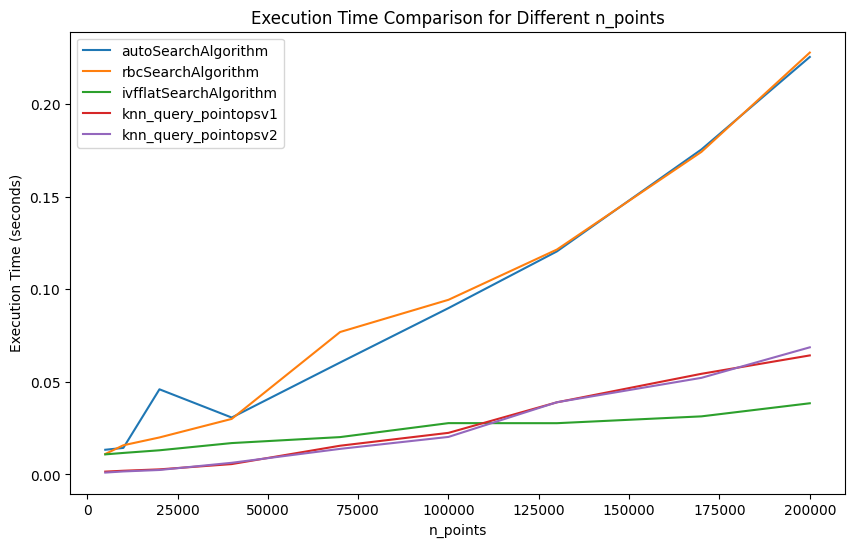

In [27]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import gc


# List of n_points values / The values 5000 to 200000 are used for the comparison of the functions and they will show the crossing point of the functions for a n_list of 100 and a n_probe of 2
n_points_list = [5000, 10000, 20000, 40000, 70000, 100000, 130000, 170000, 200000] # Do not use a number above 5500000 if your GPU Memory is 16GB

# Lists to store execution times for each function
execution_times_auto = []
execution_times_rbc = []
execution_times_ivfflat = []
execution_times_pointopsv1 = []
execution_times_pointopsv2 = []

# Loop over n_points values
for n_points in n_points_list:

    # Empty GPU memory usage of cuDF
    torch.cuda.empty_cache()
    gc.collect()

    print(f"Current n_points: {n_points}")

    # Generate random data for the DataFrame
    point_cloud = torch.cuda.FloatTensor(n_points, 3).uniform_()

    # Generate random data for the DataFrame
    random_data = np.array(point_cloud.cpu())

    # Create the cudf.DataFrame
    df = cudf.DataFrame(random_data, columns=["X", "Y", "Z"])

    # Call the functions and measure execution time
    distances_auto, indices_auto, execution_time_auto = autoSearchAlgorithm(df)
    distances_rbc, indices_rbc, execution_time_rbc = rbcSearchAlgorithm(df)
    distances_ivfflat, indices_ivfflat, execution_time_ivfflat = ivfflatSearchAlgorithm(df, best_nlist, best_nprobe)
    reference_index_cpu, execution_time_pointopsv1, distanceindex_pointopsv1 = knn_query_pointopsv1(n_neighbors, point_cloud, n_points)
    reference_index_cpu2, execution_time_pointopsv2, distanceindex_pointopsv2 = knn_query_pointopsv2(n_neighbors, point_cloud, n_points)

    # Compare element-wise equality
    equal_auto_rbc = torch.eq(torch.tensor(indices_auto.values), torch.tensor(indices_rbc.values))
    equal_auto_ivfflat = torch.eq(torch.tensor(indices_auto.values), torch.tensor(indices_ivfflat.values))
    equal_rbc_ivfflat = torch.eq(torch.tensor(indices_rbc.values), torch.tensor(indices_ivfflat.values))

    # Find indices where elements are different
    differences_auto_rbc = torch.nonzero(~equal_auto_rbc)
    differences_auto_ivfflat = torch.nonzero(~equal_auto_ivfflat)
    differences_rbc_ivfflat = torch.nonzero(~equal_rbc_ivfflat)

    # Print the number of differences
    print(f"Number of differences between indices_auto and indices_rbc: {len(differences_auto_rbc)}")
    print(f"Number of differences between indices_auto and indices_ivfflat: {len(differences_auto_ivfflat)}")
    print(f"Number of differences between indices_rbc and indices_ivfflat: {len(differences_rbc_ivfflat)}")

    # Append execution times to the respective lists
    execution_times_auto.append(execution_time_auto)
    execution_times_rbc.append(execution_time_rbc)
    execution_times_ivfflat.append(execution_time_ivfflat)
    execution_times_pointopsv1.append(execution_time_pointopsv1)
    execution_times_pointopsv2.append(execution_time_pointopsv2)


    # Compare element-wise equality
    equal_distances_auto_rbc = torch.eq(torch.tensor(distances_auto.values), torch.tensor(distances_rbc.values))
    equal_distances_auto_ivfflat = torch.eq(torch.tensor(distances_auto.values), torch.tensor(distances_ivfflat.values))
    equal_distances_rbc_ivfflat = torch.eq(torch.tensor(distances_rbc.values), torch.tensor(distances_ivfflat.values))

    # Find indices where elements are different
    differences_distances_auto_rbc = torch.nonzero(~equal_distances_auto_rbc)
    differences_distances_auto_ivfflat = torch.nonzero(~equal_distances_auto_ivfflat)
    differences_distances_rbc_ivfflat = torch.nonzero(~equal_distances_rbc_ivfflat)

    # Calculate the average distance error for the differences
    average_distance_error_auto_rbc = torch.mean(torch.abs(torch.tensor(distances_auto.values)[differences_distances_auto_rbc] - torch.tensor(distances_rbc.values)[differences_distances_auto_rbc]))

    average_distance_error_auto_ivfflat = torch.mean(torch.abs(torch.tensor(distances_auto.values)[differences_distances_auto_ivfflat] - torch.tensor(distances_ivfflat.values)[differences_distances_auto_ivfflat]))
    
    average_distance_error_rbc_ivfflat = torch.mean(torch.abs(torch.tensor(distances_rbc.values)[differences_distances_rbc_ivfflat] - torch.tensor(distances_ivfflat.values)[differences_distances_rbc_ivfflat]))

    # Print the average distance errors
    print(f"Average distance error between distances_auto and distances_rbc: {average_distance_error_auto_rbc}")
    print(f"Average distance error between distances_auto and distances_ivfflat: {average_distance_error_auto_ivfflat}")
    print(f"Average distance error between distances_rbc and distances_ivfflat: {average_distance_error_rbc_ivfflat}")

# Create a DataFrame to store the execution times
execution_times_df = pd.DataFrame({
    'n_points': n_points_list,
    'autoSearchAlgorithm': execution_times_auto,
    'rbcSearchAlgorithm': execution_times_rbc,
    'ivfflatSearchAlgorithm': execution_times_ivfflat,
    'knn_query_pointopsv1': execution_times_pointopsv1,
    'knn_query_pointopsv2': execution_times_pointopsv2
})

# Plotting the execution times
plt.figure(figsize=(10, 6))
plt.plot(execution_times_df['n_points'], execution_times_df['autoSearchAlgorithm'], label='autoSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['rbcSearchAlgorithm'], label='rbcSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['ivfflatSearchAlgorithm'], label='ivfflatSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['knn_query_pointopsv1'], label='knn_query_pointopsv1')
plt.plot(execution_times_df['n_points'], execution_times_df['knn_query_pointopsv2'], label='knn_query_pointopsv2')
plt.xlabel('n_points')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison for Different n_points')
plt.legend()
plt.show()


In [28]:
import pandas as pd

# Convert the differences_auto_ivfflat to a pandas DataFrame
df_differences = pd.DataFrame(torch.tensor(indices_ivfflat.values).numpy())

# Save the DataFrame to a CSV file
df_differences.to_csv('differences_auto_ivfflat.csv', index=False)


In [29]:
execution_times_df.to_csv('execution_times.csv', index=False)


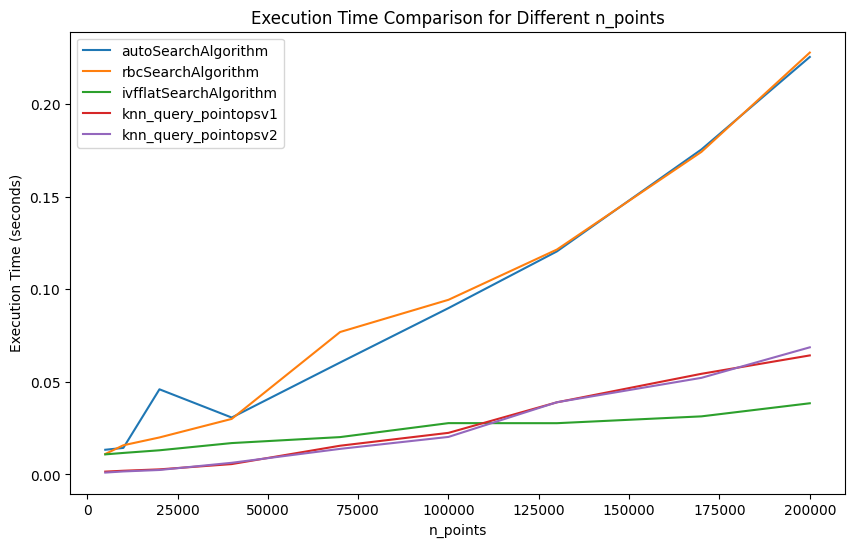

In [30]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
execution_times_df = pd.read_csv('execution_times.csv')

# Plotting the execution times
plt.figure(figsize=(10, 6))
plt.plot(execution_times_df['n_points'], execution_times_df['autoSearchAlgorithm'], label='autoSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['rbcSearchAlgorithm'], label='rbcSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['ivfflatSearchAlgorithm'], label='ivfflatSearchAlgorithm')
plt.plot(execution_times_df['n_points'], execution_times_df['knn_query_pointopsv1'], label='knn_query_pointopsv1')
plt.plot(execution_times_df['n_points'], execution_times_df['knn_query_pointopsv2'], label='knn_query_pointopsv2')
plt.xlabel('n_points')
plt.ylabel('Execution Time (seconds)')
plt.title('Execution Time Comparison for Different n_points')
plt.legend()
plt.show()


In [31]:
import torch

torch.cuda.empty_cache()

import gc

# Empty GPU memory usage of cuDF
gc.collect()


8832